# 把split作为标准,评价gim的精度

In [1]:
!pwd

/panda/eedy/ion_los-angle/s1_a064/notebook


In [2]:
from datetime import datetime
from mintpy.utils import ptime, readfile, writefile
import h5py
import numpy as np
from matplotlib import pyplot as plt, colorbar, ticker, colors
from mintpy.utils import ptime, readfile, writefile
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import subprocess
from mintpy.objects import timeseries
import math

In [3]:
# 定义文件路径
path_split = '../mintpy_split_ion_upsample/ion.h5'
path_GIM = '../mintpy_gim_ion_upsample/ion.h5'
path_hight_GIM = '../mintpy_hight_gim_ion_upsample/ion.h5'

## 1.设为同一参考点和参考时间

In [4]:
# 构建文件路径列表
file_paths = [path_split, path_GIM, path_hight_GIM]

# 遍历文件路径列表，依次执行 reference_point.py 和 reference_date.py 命令
for file_path in file_paths:
    # 构建 reference_point.py 命令
    ref_point_command = ['reference_point.py', file_path, '-y', '350', '-x', '100']
    try:
        # 执行 reference_point.py 命令
        subprocess.run(ref_point_command, check=True)
        print(f"针对 {file_path} 执行 reference_point.py 命令成功")
    except subprocess.CalledProcessError as e:
        print(f"针对 {file_path} 执行 reference_point.py 命令失败: {e}")

    # 构建 reference_date.py 命令
    ref_date_command = ['reference_date.py', file_path, '--ref-date', '20190123']
    try:
        # 执行 reference_date.py 命令
        subprocess.run(ref_date_command, check=True)
        print(f"针对 {file_path} 执行 reference_date.py 命令成功")
    except subprocess.CalledProcessError as e:
        print(f"针对 {file_path} 执行 reference_date.py 命令失败: {e}")

--------------------------------------------------
input reference point in y/x: (350, 100)
--------------------------------------------------
calculating the temporal average of timeseries file: ../mintpy_split_ion_upsample/ion.h5
reading timeseries data from file: ../mintpy_split_ion_upsample/ion.h5 ...
updating dataset values without re-writing to a new file
update metadata
针对 ../mintpy_split_ion_upsample/ion.h5 执行 reference_point.py 命令成功
input reference date: 20190123
--------------------------------------------------
change reference date for file: /panda/eedy/ion_los-angle/s1_a064/mintpy_split_ion_upsample/ion.h5
reading data ...
referencing in time ...
--------------------------------------------------
open  HDF5 file /panda/eedy/ion_los-angle/s1_a064/mintpy_split_ion_upsample/ion.h5 in r+ mode
writing dataset /timeseries                block: (0, 281, 0, 690, 0, 229)
close HDF5 file /panda/eedy/ion_los-angle/s1_a064/mintpy_split_ion_upsample/ion.h5.
update "REF_DATE" attribute 

## 2.读取ion的时间序列，用左上角右下角的值，获取距离和方位向坡度的时间序列

In [5]:
# 构建文件路径列表
file_paths = [path_split, path_GIM, path_hight_GIM]
# 初始化存储 timeseries和dates 数据的列表
timeseries_list = []
timeseries_list = []
dates_list = []

# 循环读取每个文件的 timeseries 数据并进行处理
for path in file_paths:
    # 读取 timeseries 数据
    time_series = readfile.read(path, datasetName='timeseries')[0]
    time_series = np.squeeze(time_series)
    timeseries_list.append(time_series)

    # 读取日期数据
    obj = timeseries(path)
    obj.open()
    dates = ptime.date_list2vector(obj.dateList)[0]
    dates_list.append(dates)

# 将处理后的数据分别赋值给对应的变量
timeseries_split, timeseries_GIM, timeseries_hight_GIM = timeseries_list
dates_split, dates_GIM, dates_hight_GIM = dates_list

time_series,art = readfile.read(path_split, datasetName='timeseries')
a_piexl = float(art['AZIMUTH_PIXEL_SIZE'])
r_piexl = float(art['RANGE_PIXEL_SIZE'])

open timeseries file: ion.h5
open timeseries file: ion.h5
open timeseries file: ion.h5


In [6]:
dates_split = np.array(dates_split)
dates_GIM = np.array(dates_GIM)
dates_hight_GIM = np.array(dates_hight_GIM)

# 找出三个日期数组的交集
common_dates = np.intersect1d(np.intersect1d(dates_split, dates_GIM), dates_hight_GIM)

# 确定每个日期数组中重叠日期对应的索引
indices_split = np.isin(dates_split, common_dates)
indices_GIM = np.isin(dates_GIM, common_dates)
indices_hight_GIM = np.isin(dates_hight_GIM, common_dates)

# 根据索引提取重叠时间部分的数据
timeseries_split = timeseries_split[indices_split]
timeseries_GIM = timeseries_GIM[indices_GIM]
timeseries_hight_GIM = timeseries_hight_GIM[indices_hight_GIM]

# 同时更新日期数组为重叠的日期
dates_split = dates_split[indices_split]
dates_GIM = dates_GIM[indices_GIM]
dates_hight_GIM = dates_hight_GIM[indices_hight_GIM]

In [7]:
dates = dates_split

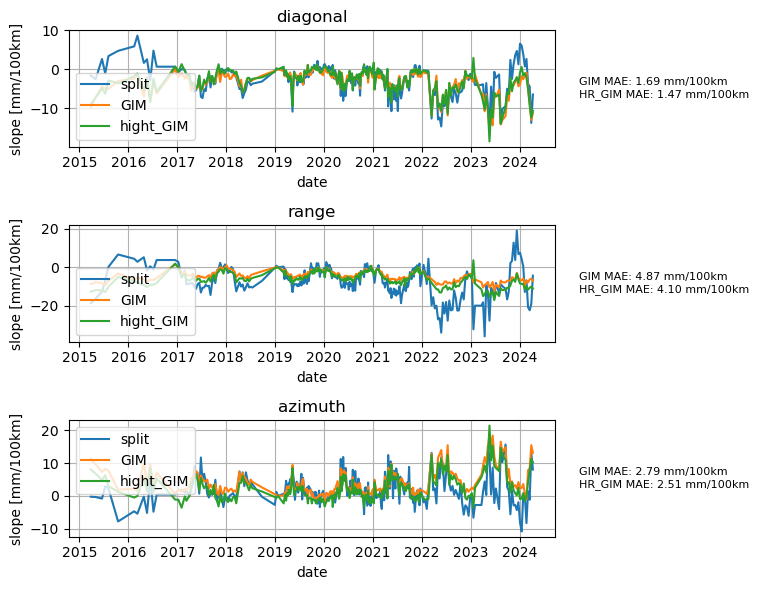

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt

def calculate_diff_and_plot(ax, x1, y1, x2, y2, title):
    # 计算两点间的实际物理距离
    distance = math.sqrt((abs(x1 - x2) * r_piexl) ** 2 + (abs(y1 - y2) * a_piexl) ** 2)
    # 计算每个数据集在两个点的差值的时间序列
    diff_split = timeseries_split[:, y1, x1] - timeseries_split[:, y2, x2]
    diff_split = diff_split / distance * 1e8
    diff_GIM = timeseries_GIM[:, y1, x1] - timeseries_GIM[:, y2, x2]
    diff_GIM = diff_GIM / distance * 1e8
    diff_hight_GIM = timeseries_hight_GIM[:, y1, x1] - timeseries_hight_GIM[:, y2, x2]
    diff_hight_GIM = diff_hight_GIM / distance * 1e8
    
    # 计算MAE误差
    mae_GIM = np.mean(np.abs(diff_GIM - diff_split))
    mae_hight_GIM = np.mean(np.abs(diff_hight_GIM - diff_split))
    
    # 在子图中绘制时间序列
    ax.plot(dates, diff_split, label='split')
    ax.plot(dates, diff_GIM, label='GIM')
    ax.plot(dates, diff_hight_GIM, label='hight_GIM')
    ax.set_title(title)
    ax.set_xlabel('date')
    ax.set_ylabel('slope [mm/100km]')
    ax.legend()
    ax.grid(True)
    
    # 在右侧添加误差文本
    textstr = (f'GIM MAE: {mae_GIM:.2f} mm/100km \n'
               f'HR_GIM MAE: {mae_hight_GIM:.2f} mm/100km ')
    ax.text(1.05, 0.5, textstr, transform=ax.transAxes, 
            va='center', ha='left', fontsize=8)
    
    return diff_split, diff_GIM, diff_hight_GIM, dates

# 创建图形并调整布局
fig, axes = plt.subplots(3, 1, figsize=(8, 6))  # 增加宽度以适应文本
# 绘制子图
calculate_diff_and_plot(axes[0], 50, 600, 200, 70, 'diagonal')
calculate_diff_and_plot(axes[1], 50, 600, 200, 600, 'range')
calculate_diff_and_plot(axes[2],  200, 60, 200, 70, 'azimuth')
# 调整布局
plt.tight_layout()
plt.subplots_adjust(right=0.7)  # 为右侧文本留出空间
plt.show()

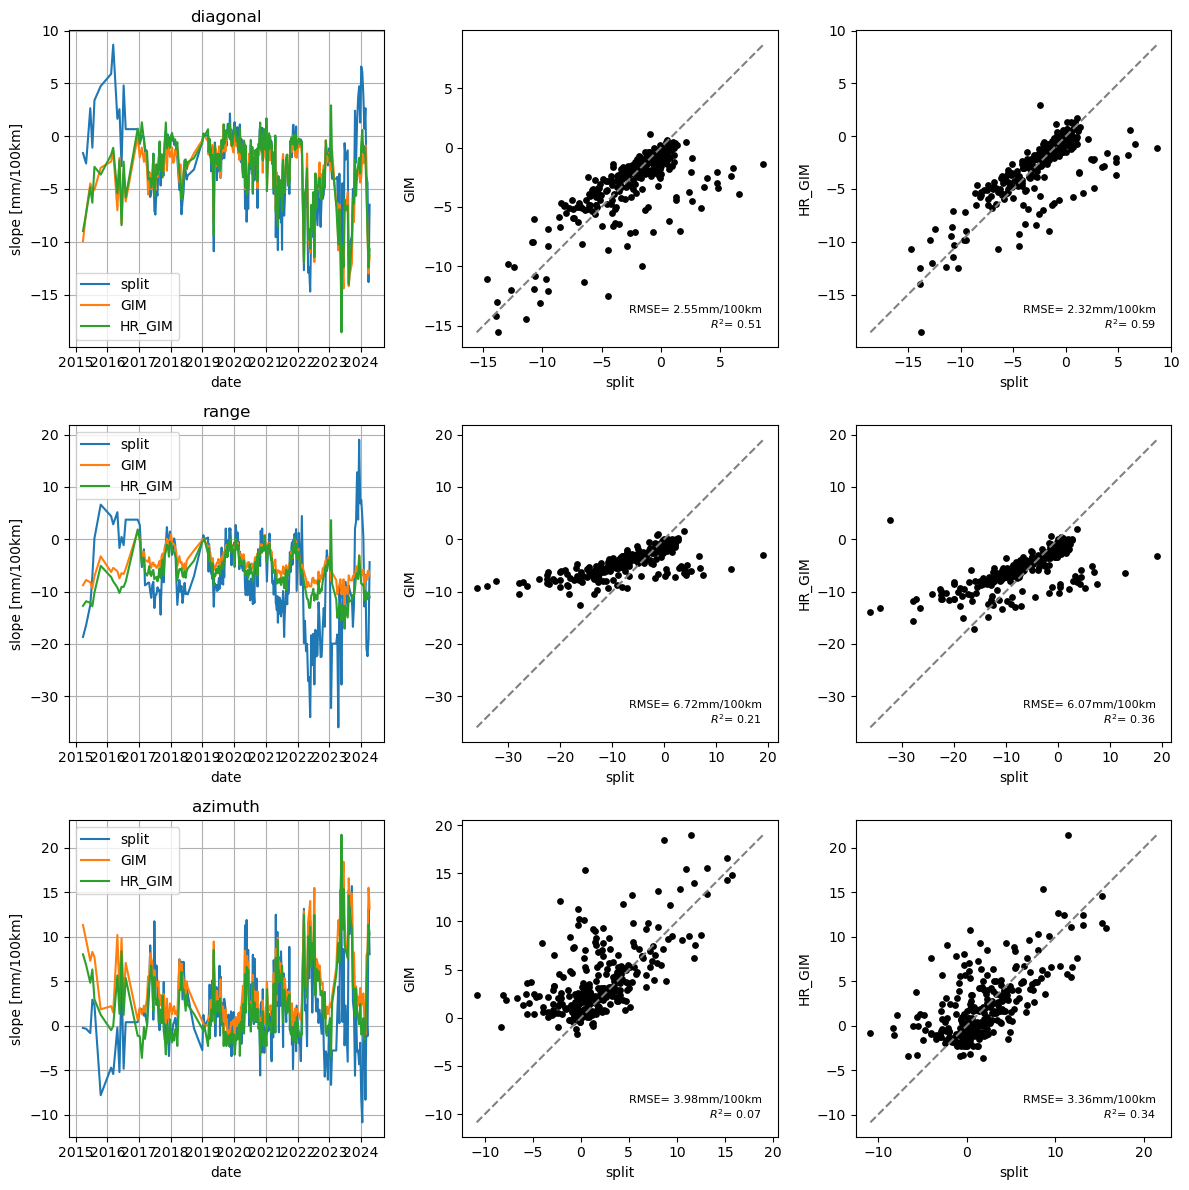

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def calculate_diff_and_plot(ax, x1, y1, x2, y2, title):
    # 计算两点间的实际物理距离
    distance = math.sqrt((abs(x1 - x2) * r_piexl) ** 2 + (abs(y1 - y2) * a_piexl) ** 2)
    # 计算每个数据集在两个点的差值的时间序列
    diff_split = timeseries_split[:, y1, x1] - timeseries_split[:, y2, x2]
    diff_split = diff_split / distance * 1e8
    diff_GIM = timeseries_GIM[:, y1, x1] - timeseries_GIM[:, y2, x2]
    diff_GIM = diff_GIM / distance * 1e8
    diff_hight_GIM = timeseries_hight_GIM[:, y1, x1] - timeseries_hight_GIM[:, y2, x2]
    diff_hight_GIM = diff_hight_GIM / distance * 1e8

    # 在子图中绘制时间序列
    ax.plot(dates, diff_split, label='split')
    ax.plot(dates, diff_GIM, label='GIM')
    ax.plot(dates, diff_hight_GIM, label='HR_GIM')
    ax.set_title(title)
    ax.set_xlabel('date')
    ax.set_ylabel('slope [mm/100km]')
    ax.legend()
    ax.grid(True)

    return diff_split, diff_GIM, diff_hight_GIM, dates

def plot_scatter_and_metrics(ax, diff_split, diff_other, label):
    # 计算RMSE和R2
    rmse = np.sqrt(mean_squared_error(diff_split, diff_other))
    r2 = r2_score(diff_split, diff_other)

    # 绘制散点图，设置散点颜色为黑色
    ax.scatter(diff_split, diff_other, s=15, label=label, color='black')
    ax.set_xlabel('split')
    ax.set_ylabel(label)
    ax.grid(False)

    # 绘制 x = y 的虚线
    min_val = min(np.min(diff_split), np.min(diff_other))
    max_val = max(np.max(diff_split), np.max(diff_other))
    ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray')

    # 在右下角添加RMSE和R2文本
    textstr = (f'RMSE= {rmse:.2f}mm/100km\n'
               f'$R^{2}$= {r2:.2f}')
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes,
            va='bottom', ha='right', fontsize=8)

# 创建主图形并调整布局，变为3行4列的子图布局
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# 绘制时间序列子图并获取差值序列
diff_splits = []
diff_GIMs = []
diff_hight_GIMs = []
# 绘制子图
for i, (x1, y1, x2, y2, title) in enumerate([(50, 600, 200, 70, 'diagonal'),
                                              (50, 600, 200, 600, 'range'),
                                              (200, 60, 200, 70, 'azimuth')]):
    diff_split, diff_GIM, diff_hight_GIM, dates = calculate_diff_and_plot(axes[i, 0], x1, y1, x2, y2, title)
    diff_splits.append(diff_split)
    diff_GIMs.append(diff_GIM)
    diff_hight_GIMs.append(diff_hight_GIM)

    # 绘制 diff_split 与 diff_GIM 的散点图
    plot_scatter_and_metrics(axes[i, 1], diff_split, diff_GIM, 'GIM')
    # 绘制 diff_split 与 diff_hight_GIM 的散点图
    plot_scatter_and_metrics(axes[i, 2], diff_split, diff_hight_GIM, 'HR_GIM')

# 调整布局
plt.tight_layout()
plt.show()

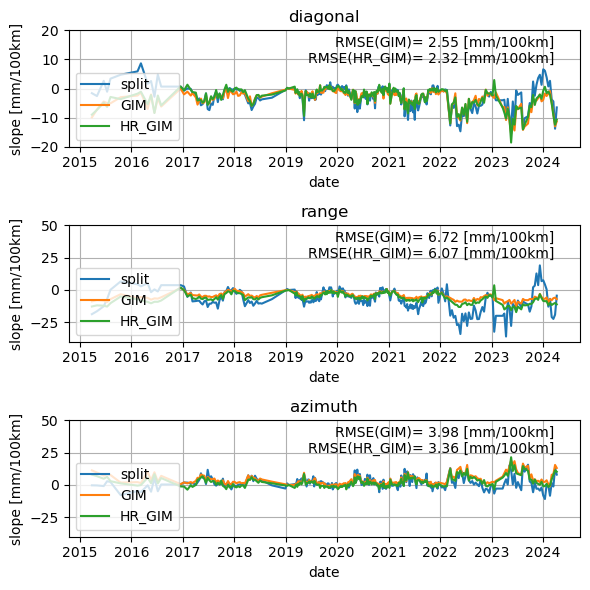

In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def calculate_diff_and_plot(ax, x1, y1, x2, y2, title, ylim):
    # 计算两点间的实际物理距离
    distance = math.sqrt((abs(x1 - x2) * r_piexl) ** 2 + (abs(y1 - y2) * a_piexl) ** 2)
    # 计算每个数据集在两个点的差值的时间序列
    diff_split = timeseries_split[:, y1, x1] - timeseries_split[:, y2, x2]
    diff_split = diff_split / distance * 1e8
    diff_GIM = timeseries_GIM[:, y1, x1] - timeseries_GIM[:, y2, x2]
    diff_GIM = diff_GIM / distance * 1e8
    diff_hight_GIM = timeseries_hight_GIM[:, y1, x1] - timeseries_hight_GIM[:, y2, x2]
    diff_hight_GIM = diff_hight_GIM / distance * 1e8

    # 在子图中绘制时间序列
    ax.plot(dates, diff_split, label='split')
    ax.plot(dates, diff_GIM, label='GIM')
    ax.plot(dates, diff_hight_GIM, label='HR_GIM')
    ax.set_title(title)
    ax.set_xlabel('date')
    ax.set_ylabel('slope [mm/100km]')
    ax.legend(loc='lower left')
    ax.grid(True)
    

    # 计算RMSE
    rmse_GIM = np.sqrt(mean_squared_error(diff_split, diff_GIM))
    rmse_hight_GIM = np.sqrt(mean_squared_error(diff_split, diff_hight_GIM))

    # 在右上角添加RMSE和R2文本
    textstr_GIM = (f'RMSE(GIM)= {rmse_GIM:.2f} [mm/100km]')
    textstr_hight_GIM = (f'RMSE(HR_GIM)= {rmse_hight_GIM:.2f} [mm/100km]')
    ax.text(0.95, 0.95, textstr_GIM + '\n' + textstr_hight_GIM, transform=ax.transAxes,
            va='top', ha='right')

    # 设置y轴范围
    ax.set_ylim(ylim)

    return diff_split, diff_GIM, diff_hight_GIM, dates

# 创建主图形并调整布局，变为3行1列的子图布局
fig, axes = plt.subplots(3, 1, figsize=(6, 6))

# 定义每个子图的y轴范围
y_limits = [(-20, 20), (-40, 50), (-40, 50)]

# 绘制子图
for i, (x1, y1, x2, y2, title) in enumerate([(50, 600, 200, 70, 'diagonal'),
                                              (50, 600, 200, 600, 'range'),
                                              (200, 60, 200, 70, 'azimuth')]):
    calculate_diff_and_plot(axes[i], x1, y1, x2, y2, title, y_limits[i])

# 调整布局
plt.tight_layout()
plt.savefig('ion_ramp_ra.png', bbox_inches='tight', transparent=True, dpi=600)
plt.show()